<a href="https://colab.research.google.com/github/qwerty12646/code/blob/main/%EC%B0%90%EC%B5%9C%EC%A2%85%EC%9E%85%EC%A7%80%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install osmnx
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 31.1 MB/s eta 0:00:00


In [2]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.sparse import lil_matrix
from pulp import *
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

print("=== 데이터 로드 ===")

# 데이터 로드
demand_filtered = gpd.read_file("demand_filtered.geojson")
candidate = gpd.read_file("totaltoalcandidates.geojson")
priority_zone = gpd.read_file("priority_zone.geojson")

print(f"필터링된 수요점: {len(demand_filtered)}개")
print(f"후보 정류장: {len(candidate)}개")
print(f"우선순위 지역 경계: {len(priority_zone)}개")

# CRS 확인 및 통일
print(f"\n수요 데이터 CRS: {demand_filtered.crs}")
print(f"후보지 CRS: {candidate.crs}")
print(f"우선순위 지역 CRS: {priority_zone.crs}")

if demand_filtered.crs != 'EPSG:4326':
    demand_filtered = demand_filtered.to_crs('EPSG:4326')
if candidate.crs != 'EPSG:4326':
    candidate = candidate.to_crs('EPSG:4326')
if priority_zone.crs != 'EPSG:4326':
    priority_zone = priority_zone.to_crs('EPSG:4326')

# demand_total 컬럼 확인
# -----------------------------------------------------
# [수정 코드] sum_value 컬럼을 MCLP 수요 가중치로 사용
# -----------------------------------------------------

# -----------------------------------------------------
# [추가 코드] sum_value가 0인 수요점 필터링
# -----------------------------------------------------

# 1. 'sum_value' 컬럼을 'demand_total'로 지정 (이전 단계 보완)
if 'sum_value' in demand_filtered.columns:
    demand_filtered['demand_total'] = demand_filtered['sum_value']

    # 2. demand_total (sum_value)이 0 초과인 데이터만 남기고 필터링
    initial_count = len(demand_filtered)
    demand_filtered = demand_filtered[demand_filtered['demand_total'] > 0].copy()

    removed_count = initial_count - len(demand_filtered)
    print(f"✅ 'sum_value'가 0인 수요점 {removed_count}개를 필터링했습니다.")
    print(f"✅ 최종 수요점 개수: {len(demand_filtered)}, 총 수요: {demand_filtered['demand_total'].sum()}.")

elif 'demand_total' not in demand_filtered.columns:
    print("⚠️ 'sum_value' 컬럼을 찾을 수 없습니다. 균등 가중치(1)를 사용합니다.")
    demand_filtered['demand_total'] = 1

# -----------------------------------------------------

print("✅ 데이터 로드 완료")

=== 데이터 로드 ===
필터링된 수요점: 3620개
후보 정류장: 3700개
우선순위 지역 경계: 61개

수요 데이터 CRS: EPSG:5179
후보지 CRS: EPSG:5179
우선순위 지역 CRS: EPSG:5179
✅ 'sum_value'가 0인 수요점 2754개를 필터링했습니다.
✅ 최종 수요점 개수: 866, 총 수요: 12764.
✅ 데이터 로드 완료


In [3]:
print("\n=== 도보망 다운로드 (후보지 전체 범위) ===")

# 후보지 전체 범위로 도보망 다운로드
candidate_bbox = candidate.total_bounds

print(f"대상 지역 범위: {candidate_bbox}")
print("⚠️ 도보망 다운로드 중... (시간이 오래 걸릴 수 있습니다 - 10~30분 예상)")

try:
    # Bounding Box로 도보망 다운로드
    G_walk = ox.graph_from_bbox(
        north=candidate_bbox[3],
        south=candidate_bbox[1],
        east=candidate_bbox[2],
        west=candidate_bbox[0],
        network_type='walk',
        simplify=True
    )
    print(f"✅ 도보망 로드 완료: {len(G_walk.nodes)} 노드, {len(G_walk.edges)} 엣지")

except Exception as e:
    print(f"⚠️ Bbox 방식 실패: {e}")
    print("Polygon 방식으로 재시도...")

    # Polygon으로 다운로드 (대안)
    candidate_polygon = box(*candidate_bbox)

    G_walk = ox.graph_from_polygon(
        candidate_polygon,
        network_type='walk',
        simplify=True
    )
    print(f"✅ 도보망 로드 완료: {len(G_walk.nodes)} 노드, {len(G_walk.edges)} 엣지")

# 도보 시간 계산을 위한 속성 추가 (평균 도보 속도: 4.5 km/h)
print("도보 시간 속성 추가 중...")
G_walk = ox.add_edge_speeds(G_walk, hwy_speeds={'footway': 4.5, 'path': 4.5,
                                                   'pedestrian': 4.5, 'steps': 3.0,
                                                   'track': 4.0, 'unclassified': 4.5})
G_walk = ox.add_edge_travel_times(G_walk)

print("✅ 도보망 준비 완료")


=== 도보망 다운로드 (후보지 전체 범위) ===
대상 지역 범위: [127.6224512   34.63547636 129.1958811   35.83826388]
⚠️ 도보망 다운로드 중... (시간이 오래 걸릴 수 있습니다 - 10~30분 예상)
⚠️ Bbox 방식 실패: graph_from_bbox() got an unexpected keyword argument 'north'
Polygon 방식으로 재시도...
✅ 도보망 로드 완료: 293894 노드, 814886 엣지
도보 시간 속성 추가 중...
✅ 도보망 준비 완료


In [4]:
print("\n=== 네트워크 매칭 시작 ===")

# 수요점을 가장 가까운 네트워크 노드에 매칭
print("수요점을 도보망 노드에 매칭 중...")
demand_filtered['nearest_node'] = ox.distance.nearest_nodes(
    G_walk,
    demand_filtered.geometry.x,
    demand_filtered.geometry.y
)

# 후보지를 가장 가까운 네트워크 노드에 매칭
print("후보지를 도보망 노드에 매칭 중...")
candidate['nearest_node'] = ox.distance.nearest_nodes(
    G_walk,
    candidate.geometry.x,
    candidate.geometry.y
)

# 중복 제거
demand_nodes = demand_filtered['nearest_node'].unique()
candidate_nodes = candidate['nearest_node'].unique()

print(f"✅ 매칭 완료")
print(f"  - 고유 수요 노드: {len(demand_nodes)}개")
print(f"  - 고유 후보 노드: {len(candidate_nodes)}개")

# 매칭 품질 확인
print("\n매칭 품질 확인 중...")
node_coords = {node: (data['x'], data['y']) for node, data in G_walk.nodes(data=True)}

demand_filtered['match_distance_m'] = 0.0
for idx, row in demand_filtered.iterrows():
    nearest = row['nearest_node']
    if nearest in node_coords:
        node_x, node_y = node_coords[nearest]
        dx = (row.geometry.x - node_x) * 111000 * np.cos(np.radians(row.geometry.y))
        dy = (row.geometry.y - node_y) * 111000
        distance = np.sqrt(dx**2 + dy**2)
        demand_filtered.at[idx, 'match_distance_m'] = distance

print("\n=== 매칭 품질 ===")
print(f"수요점-네트워크 거리 통계:")
print(f"  평균: {demand_filtered['match_distance_m'].mean():.1f}m")
print(f"  중앙값: {demand_filtered['match_distance_m'].median():.1f}m")
print(f"  최대: {demand_filtered['match_distance_m'].max():.1f}m")
print(f"  500m 이상: {(demand_filtered['match_distance_m'] > 500).sum()}개")
print(f"  1km 이상: {(demand_filtered['match_distance_m'] > 1000).sum()}개")

# 너무 멀리 떨어진 수요점 제거 (선택사항)
MAX_MATCH_DISTANCE = 2000  # 2km
before_filter = len(demand_filtered)
demand_filtered = demand_filtered[demand_filtered['match_distance_m'] <= MAX_MATCH_DISTANCE].copy()
print(f"\n거리 필터링 ({MAX_MATCH_DISTANCE}m 이내만): {before_filter}개 → {len(demand_filtered)}개")

# 노드 리스트 업데이트
demand_nodes = demand_filtered['nearest_node'].unique()
print(f"최종 수요 노드: {len(demand_nodes)}개")


=== 네트워크 매칭 시작 ===
수요점을 도보망 노드에 매칭 중...
후보지를 도보망 노드에 매칭 중...
✅ 매칭 완료
  - 고유 수요 노드: 819개
  - 고유 후보 노드: 3380개

매칭 품질 확인 중...

=== 매칭 품질 ===
수요점-네트워크 거리 통계:
  평균: 715.1m
  중앙값: 192.6m
  최대: 20093.1m
  500m 이상: 145개
  1km 이상: 62개

거리 필터링 (2000m 이내만): 866개 → 817개
최종 수요 노드: 805개


In [5]:
# MCLP 파라미터 설정
R_seconds = 900  # 15분 (900초) 도보 시간 기준

print(f"\n=== OD Matrix 계산 시작 ===")
print(f"커버리지 기준: R = {R_seconds}초 ({R_seconds/60:.0f}분 도보 시간)")
print(f"계산 규모: {len(demand_nodes)} × {len(candidate_nodes)} = {len(demand_nodes) * len(candidate_nodes):,} 쌍")
print("⚠️ 이 과정은 수요점과 후보지 수에 따라 오래 걸릴 수 있습니다...")

# Coverage Matrix 생성 (희소 행렬)
coverage_matrix = lil_matrix((len(demand_nodes), len(candidate_nodes)), dtype=bool)

# 노드 인덱스 매핑
demand_node_to_idx = {node: i for i, node in enumerate(demand_nodes)}
candidate_node_to_idx = {node: j for j, node in enumerate(candidate_nodes)}

# 각 후보지에서 도달 가능한 수요점 계산
total_candidates = len(candidate_nodes)
for j, candidate_node in enumerate(candidate_nodes):
    if j % 50 == 0:
        progress = (j / total_candidates) * 100
        print(f"진행중: {j}/{total_candidates} ({progress:.1f}%) 후보지 처리...")

    try:
        # 단일 출발지에서 모든 도착지까지의 최단 경로 길이 계산
        lengths = nx.single_source_dijkstra_path_length(
            G_walk,
            candidate_node,
            cutoff=R_seconds,
            weight='travel_time'
        )

        # 도달 가능한 수요점 체크
        for demand_node, travel_time in lengths.items():
            if demand_node in demand_node_to_idx:
                i = demand_node_to_idx[demand_node]
                coverage_matrix[i, j] = True

    except Exception as e:
        # 해당 노드에서 경로를 찾을 수 없는 경우
        continue

# 희소 행렬을 CSR 형식으로 변환 (계산 효율성)
coverage_matrix = coverage_matrix.tocsr()

coverage_density = coverage_matrix.nnz / (len(demand_nodes) * len(candidate_nodes)) * 100
print(f"\n✅ OD Matrix 계산 완료!")
print(f"  - 총 커버리지 연결: {coverage_matrix.nnz:,}개")
print(f"  - 커버리지 밀도: {coverage_density:.2f}%")

# 커버리지 통계
covered_by_at_least_one = (coverage_matrix.sum(axis=1) > 0).sum()
print(f"  - 최소 1개 이상의 후보지로 커버되는 수요점: {covered_by_at_least_one}/{len(demand_nodes)}")


=== OD Matrix 계산 시작 ===
커버리지 기준: R = 900초 (15분 도보 시간)
계산 규모: 805 × 3380 = 2,720,900 쌍
⚠️ 이 과정은 수요점과 후보지 수에 따라 오래 걸릴 수 있습니다...
진행중: 0/3380 (0.0%) 후보지 처리...
진행중: 50/3380 (1.5%) 후보지 처리...
진행중: 100/3380 (3.0%) 후보지 처리...
진행중: 150/3380 (4.4%) 후보지 처리...
진행중: 200/3380 (5.9%) 후보지 처리...
진행중: 250/3380 (7.4%) 후보지 처리...
진행중: 300/3380 (8.9%) 후보지 처리...
진행중: 350/3380 (10.4%) 후보지 처리...
진행중: 400/3380 (11.8%) 후보지 처리...
진행중: 450/3380 (13.3%) 후보지 처리...
진행중: 500/3380 (14.8%) 후보지 처리...
진행중: 550/3380 (16.3%) 후보지 처리...
진행중: 600/3380 (17.8%) 후보지 처리...
진행중: 650/3380 (19.2%) 후보지 처리...
진행중: 700/3380 (20.7%) 후보지 처리...
진행중: 750/3380 (22.2%) 후보지 처리...
진행중: 800/3380 (23.7%) 후보지 처리...
진행중: 850/3380 (25.1%) 후보지 처리...
진행중: 900/3380 (26.6%) 후보지 처리...
진행중: 950/3380 (28.1%) 후보지 처리...
진행중: 1000/3380 (29.6%) 후보지 처리...
진행중: 1050/3380 (31.1%) 후보지 처리...
진행중: 1100/3380 (32.5%) 후보지 처리...
진행중: 1150/3380 (34.0%) 후보지 처리...
진행중: 1200/3380 (35.5%) 후보지 처리...
진행중: 1250/3380 (37.0%) 후보지 처리...
진행중: 1300/3380 (38.5%) 후보지 처리...
진행중: 1350/33

In [6]:
# 수요점별 가중치 배열 생성
demand_weights = demand_filtered.groupby('nearest_node')['demand_total'].sum()
demand_weights_array = np.array([
    demand_weights.get(node, 0) for node in demand_nodes
])

total_demand = demand_weights_array.sum()
print(f"\n총 수요량: {total_demand:,.0f}")

def solve_mclp(coverage_matrix, demand_weights, p):
    """
    MCLP 문제 해결

    Parameters:
    - coverage_matrix: 커버리지 행렬 (수요점 × 후보지)
    - demand_weights: 수요점별 가중치
    - p: 선정할 시설 수

    Returns:
    - selected_facilities: 선정된 시설 인덱스 리스트
    - covered_demand: 커버된 수요량
    - coverage_rate: 커버리지율 (%)
    - y_vars_solution: 각 수요점이 커버되었는지 여부 (1: 커버됨, 0: 커버 안 됨) 리스트
    """
    n_demands = coverage_matrix.shape[0]
    n_candidates = coverage_matrix.shape[1]

    # 문제 정의
    prob = LpProblem("MCLP", LpMaximize)

    # 결정 변수
    x = [LpVariable(f"facility_{j}", cat='Binary') for j in range(n_candidates)]
    y = [LpVariable(f"demand_{i}", cat='Binary') for i in range(n_demands)]

    # 목적 함수: 커버된 수요의 가중 합 최대화
    prob += lpSum([demand_weights[i] * y[i] for i in range(n_demands)])

    # 제약 조건 1: 정확히 p개의 시설 선택
    prob += lpSum(x) == p

    # 제약 조건 2: 수요는 커버하는 시설이 하나라도 있어야 충족
    for i in range(n_demands):
        # coverage_matrix가 scipy.sparse.csr_matrix 타입이므로, 해당 행의 nonzero 인덱스를 사용
        covering_facilities = coverage_matrix[i, :].nonzero()[1].tolist()
        if covering_facilities:
            prob += y[i] <= lpSum([x[j] for j in covering_facilities])
        else:
            # 이 수요점을 커버할 수 있는 후보지가 없으면 y[i]는 항상 0
            prob += y[i] == 0

    # 문제 해결
    prob.solve(PULP_CBC_CMD(msg=0))

    # 결과 추출
    if prob.status == 1:  # Optimal solution found
        selected_facilities = [j for j in range(n_candidates) if x[j].varValue == 1]
        covered_demand = sum([demand_weights[i] * y[i].varValue for i in range(n_demands)])
        coverage_rate = covered_demand / demand_weights.sum() * 100
        y_vars_solution = [y[i].varValue for i in range(n_demands)] # 각 수요점의 커버 여부
    else:
        selected_facilities = []
        covered_demand = 0
        coverage_rate = 0
        y_vars_solution = [0] * n_demands # No solution, so no demand is covered

    return selected_facilities, covered_demand, coverage_rate, y_vars_solution

print("✅ MCLP 모델 정의 완료")


총 수요량: 12,331
✅ MCLP 모델 정의 완료


In [7]:
# p 값 범위 테스트 - 1부터 15까지
max_p = min(15, len(candidate_nodes))
p_values = list(range(1, max_p + 1))

print(f"\n=== 최적 p 값 탐색 시작 ===")
print(f"테스트 범위: p = 1 ~ {max_p} (1 단위)")

results = []

for p in p_values:
    print(f"\np = {p} 테스트 중...", end=" ")
    selected, covered, rate, _ = solve_mclp(coverage_matrix, demand_weights_array, p) # y_vars_solution은 여기서는 사용하지 않음
    results.append({
        'p': p,
        'covered_demand': covered,
        'coverage_rate': rate,
        'selected_facilities': selected
    })
    print(f"✅ 커버리지: {rate:.2f}% (수요량: {covered:,.0f})")

results_df = pd.DataFrame(results)

print("\n=== Coverage Curve 결과 ===")
print(results_df[['p', 'coverage_rate', 'covered_demand']])


=== 최적 p 값 탐색 시작 ===
테스트 범위: p = 1 ~ 15 (1 단위)

p = 1 테스트 중... ✅ 커버리지: 20.49% (수요량: 2,527)

p = 2 테스트 중... ✅ 커버리지: 31.74% (수요량: 3,914)

p = 3 테스트 중... ✅ 커버리지: 39.64% (수요량: 4,888)

p = 4 테스트 중... ✅ 커버리지: 46.28% (수요량: 5,707)

p = 5 테스트 중... ✅ 커버리지: 50.33% (수요량: 6,206)

p = 6 테스트 중... ✅ 커버리지: 53.96% (수요량: 6,654)

p = 7 테스트 중... ✅ 커버리지: 57.51% (수요량: 7,091)

p = 8 테스트 중... ✅ 커버리지: 60.91% (수요량: 7,511)

p = 9 테스트 중... ✅ 커버리지: 64.11% (수요량: 7,905)

p = 10 테스트 중... ✅ 커버리지: 66.52% (수요량: 8,203)

p = 11 테스트 중... ✅ 커버리지: 68.92% (수요량: 8,499)

p = 12 테스트 중... ✅ 커버리지: 71.12% (수요량: 8,770)

p = 13 테스트 중... ✅ 커버리지: 72.96% (수요량: 8,997)

p = 14 테스트 중... ✅ 커버리지: 74.73% (수요량: 9,215)

p = 15 테스트 중... ✅ 커버리지: 76.47% (수요량: 9,430)

=== Coverage Curve 결과 ===
     p  coverage_rate  covered_demand
0    1      20.493066          2527.0
1    2      31.741140          3914.0
2    3      39.639932          4888.0
3    4      46.281729          5707.0
4    5      50.328441          6206.0
5    6      53.961560          


=== Coverage Curve 시각화 ===


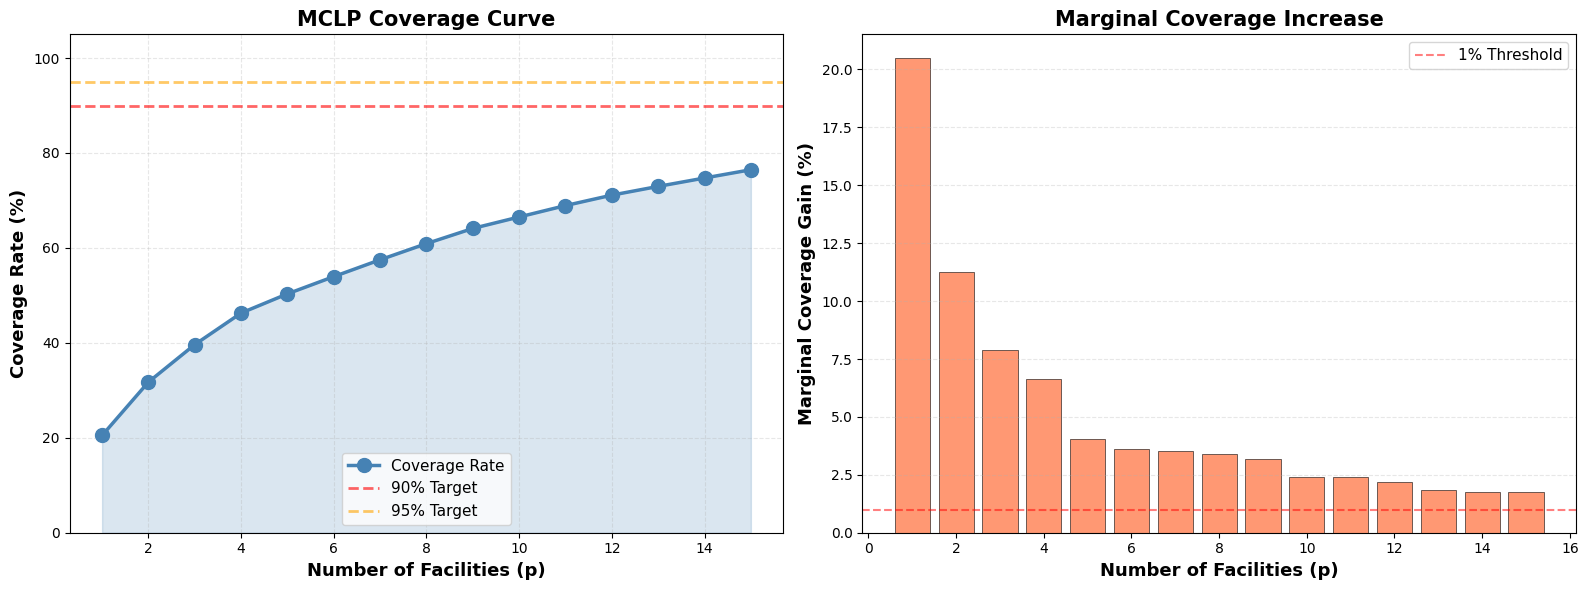

✅ Coverage Curve 저장: mclp_coverage_curve.png


In [8]:
# Coverage Curve 시각화
print("\n=== Coverage Curve 시각화 ===")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 좌측: Coverage Rate vs p
axes[0].plot(results_df['p'], results_df['coverage_rate'],
             marker='o', linewidth=2.5, markersize=10, color='steelblue', label='Coverage Rate')
axes[0].axhline(y=90, color='red', linestyle='--', alpha=0.6, linewidth=2, label='90% Target')
axes[0].axhline(y=95, color='orange', linestyle='--', alpha=0.6, linewidth=2, label='95% Target')
axes[0].fill_between(results_df['p'], 0, results_df['coverage_rate'], alpha=0.2, color='steelblue')
axes[0].set_xlabel('Number of Facilities (p)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Coverage Rate (%)', fontsize=13, fontweight='bold')
axes[0].set_title('MCLP Coverage Curve', fontsize=15, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].legend(fontsize=11)
axes[0].set_ylim([0, 105])

# 우측: Marginal Coverage Gain
marginal_gain = results_df['coverage_rate'].diff()
marginal_gain.iloc[0] = results_df['coverage_rate'].iloc[0]
colors = ['coral' if x > 1 else 'lightcoral' for x in marginal_gain]
axes[1].bar(results_df['p'], marginal_gain, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
axes[1].axhline(y=1, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='1% Threshold')
axes[1].set_xlabel('Number of Facilities (p)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Marginal Coverage Gain (%)', fontsize=13, fontweight='bold')
axes[1].set_title('Marginal Coverage Increase', fontsize=15, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y', linestyle='--')
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.savefig('mclp_coverage_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Coverage Curve 저장: mclp_coverage_curve.png")

In [9]:
# 최적 p 값 선정 로직
print("\n=== 최적 p 값 선정 ===")

# 방법 1: 90% 이상 달성하는 최소 p
optimal_90 = results_df[results_df['coverage_rate'] >= 90]
if len(optimal_90) > 0:
    p_90 = int(optimal_90.iloc[0]['p'])
    rate_90 = optimal_90.iloc[0]['coverage_rate']
    print(f"📍 90% 달성 최소 p: {p_90} (커버리지: {rate_90:.2f}%)")
else:
    p_90 = None
    print("📍 90% 달성 불가")

# 방법 2: 95% 이상 달성하는 최소 p
optimal_95 = results_df[results_df['coverage_rate'] >= 95]
if len(optimal_95) > 0:
    p_95 = int(optimal_95.iloc[0]['p'])
    rate_95 = optimal_95.iloc[0]['coverage_rate']
    print(f"📍 95% 달성 최소 p: {p_95} (커버리지: {rate_95:.2f}%)")
else:
    p_95 = None
    print("📍 95% 달성 불가")

# 방법 3: Marginal gain이 1% 미만으로 떨어지는 첫 지점
marginal_threshold = marginal_gain[marginal_gain < 1.0]
if len(marginal_threshold) > 0:
    p_marginal = int(results_df.loc[marginal_threshold.index[0], 'p'])
    rate_marginal = results_df.loc[marginal_threshold.index[0], 'coverage_rate']
    print(f"📍 Marginal gain < 1% 첫 지점: p = {p_marginal} (커버리지: {rate_marginal:.2f}%)")
else:
    p_marginal = None

# 방법 4: 최대 커버리지
p_max = int(results_df.loc[results_df['coverage_rate'].idxmax(), 'p'])
rate_max = results_df['coverage_rate'].max()
print(f"📍 최대 커버리지: p = {p_max} (커버리지: {rate_max:.2f}%)")

# ⭐ 사용자 지정: 원하는 p 값으로 설정
optimal_p = 5  # 여기를 원하는 값으로 변경

print(f"\n✅ 사용자 지정 p 값: {optimal_p}")
if optimal_p in results_df['p'].values:
    selected_rate = results_df[results_df['p'] == optimal_p]['coverage_rate'].values[0]
    print(f"선택된 커버리지: {selected_rate:.2f}%")
else:
    print(f"⚠️ 경고: p={optimal_p}는 테스트 범위에 없습니다!")
    optimal_p = p_max

print(f"\n💡 다른 p 값을 사용하려면 optimal_p 변수를 변경하세요.")
print(f"예: optimal_p = 10")


=== 최적 p 값 선정 ===
📍 90% 달성 불가
📍 95% 달성 불가
📍 최대 커버리지: p = 15 (커버리지: 76.47%)

✅ 사용자 지정 p 값: 5
선택된 커버리지: 50.33%

💡 다른 p 값을 사용하려면 optimal_p 변수를 변경하세요.
예: optimal_p = 10


In [10]:
# 최적 p로 최종 실행
print(f"\n=== 최종 MCLP 실행 (p = {optimal_p}) ===")
final_selected_indices, final_covered, final_rate, final_y_vars_solution = solve_mclp(
    coverage_matrix,
    demand_weights_array,
    optimal_p
)

# 선정된 정류장 정보 추출
selected_candidate_nodes = [candidate_nodes[i] for i in final_selected_indices]
final_selected_candidates = candidate[
    candidate['nearest_node'].isin(selected_candidate_nodes)
].copy()

# 중복 제거 (같은 노드에 여러 후보지가 매칭된 경우 첫 번째만)
final_selected_candidates = final_selected_candidates.drop_duplicates(subset=['nearest_node'])

print(f"\n=== 최종 결과 ===")
print(f"✅ 선정된 정류장 수: {len(final_selected_candidates)}")
print(f"✅ 커버된 수요량: {final_covered:,.0f} / {total_demand:,.0f}")
print(f"✅ 커버리지율: {final_rate:.2f}%")

# 결과 저장
final_selected_candidates.to_file('mclp_selected_stops.geojson', driver='GeoJSON')
print("\n💾 결과 저장: mclp_selected_stops.geojson")


=== 최종 MCLP 실행 (p = 5) ===

=== 최종 결과 ===
✅ 선정된 정류장 수: 5
✅ 커버된 수요량: 6,206 / 12,331
✅ 커버리지율: 50.33%

💾 결과 저장: mclp_selected_stops.geojson


In [11]:
# 각 수요점이 커버되는지 여부 계산
print("\n=== 커버리지 상세 분석 ===")

# MCLP 솔버의 결과를 직접 사용
demand_coverage = np.array(final_y_vars_solution).astype(bool)

# 디버깅: MCLP 결과와 demand_coverage 기반 재계산 값 확인
covered_unique_demand_node_indices = np.where(demand_coverage)[0]
recalculated_final_covered_demand = sum(demand_weights_array[i] for i in covered_unique_demand_node_indices)
print(f"[디버그] MCLP 솔버가 보고한 커버 수요량 (final_covered): {final_covered:,.0f}")
print(f"[디버그] demand_coverage 기반 재계산된 커버 수요량: {recalculated_final_covered_demand:,.0f}")

# 수요점 데이터프레임에 커버 여부 추가
demand_node_to_coverage = {node: is_covered for node, is_covered in zip(demand_nodes, demand_coverage)}
demand_filtered['is_covered'] = demand_filtered['nearest_node'].map(demand_node_to_coverage).fillna(False)

# 통계
covered = demand_filtered[demand_filtered['is_covered']].copy() # .copy() 추가하여 SettingWithCopyWarning 방지
uncovered = demand_filtered[~demand_filtered['is_covered']].copy()

print(f"커버된 수요점: {len(covered)} ({len(covered)/len(demand_filtered)*100:.1f}%) (원본 수요점 기준)")
print(f"커버 안 된 수요점: {len(uncovered)} ({len(uncovered)/len(demand_filtered)*100:.1f}%) (원본 수요점 기준)")
print(f"커버된 총 수요량: {covered['demand_total'].sum():,.0f} (원본 수요량 합계 기준)")
print(f"커버 안 된 총 수요량: {uncovered['demand_total'].sum():,.0f} (원본 수요량 합계 기준)")

# 커버리지 결과 저장
demand_filtered.to_file('demand_with_coverage.geojson', driver='GeoJSON')
print("💾 커버리지 정보 저장: demand_with_coverage.geojson")


=== 커버리지 상세 분석 ===
[디버그] MCLP 솔버가 보고한 커버 수요량 (final_covered): 6,206
[디버그] demand_coverage 기반 재계산된 커버 수요량: 6,206
커버된 수요점: 232 (28.4%) (원본 수요점 기준)
커버 안 된 수요점: 585 (71.6%) (원본 수요점 기준)
커버된 총 수요량: 6,206 (원본 수요량 합계 기준)
커버 안 된 총 수요량: 6,125 (원본 수요량 합계 기준)
💾 커버리지 정보 저장: demand_with_coverage.geojson



=== 지도 시각화 1: 전체 개요 ===


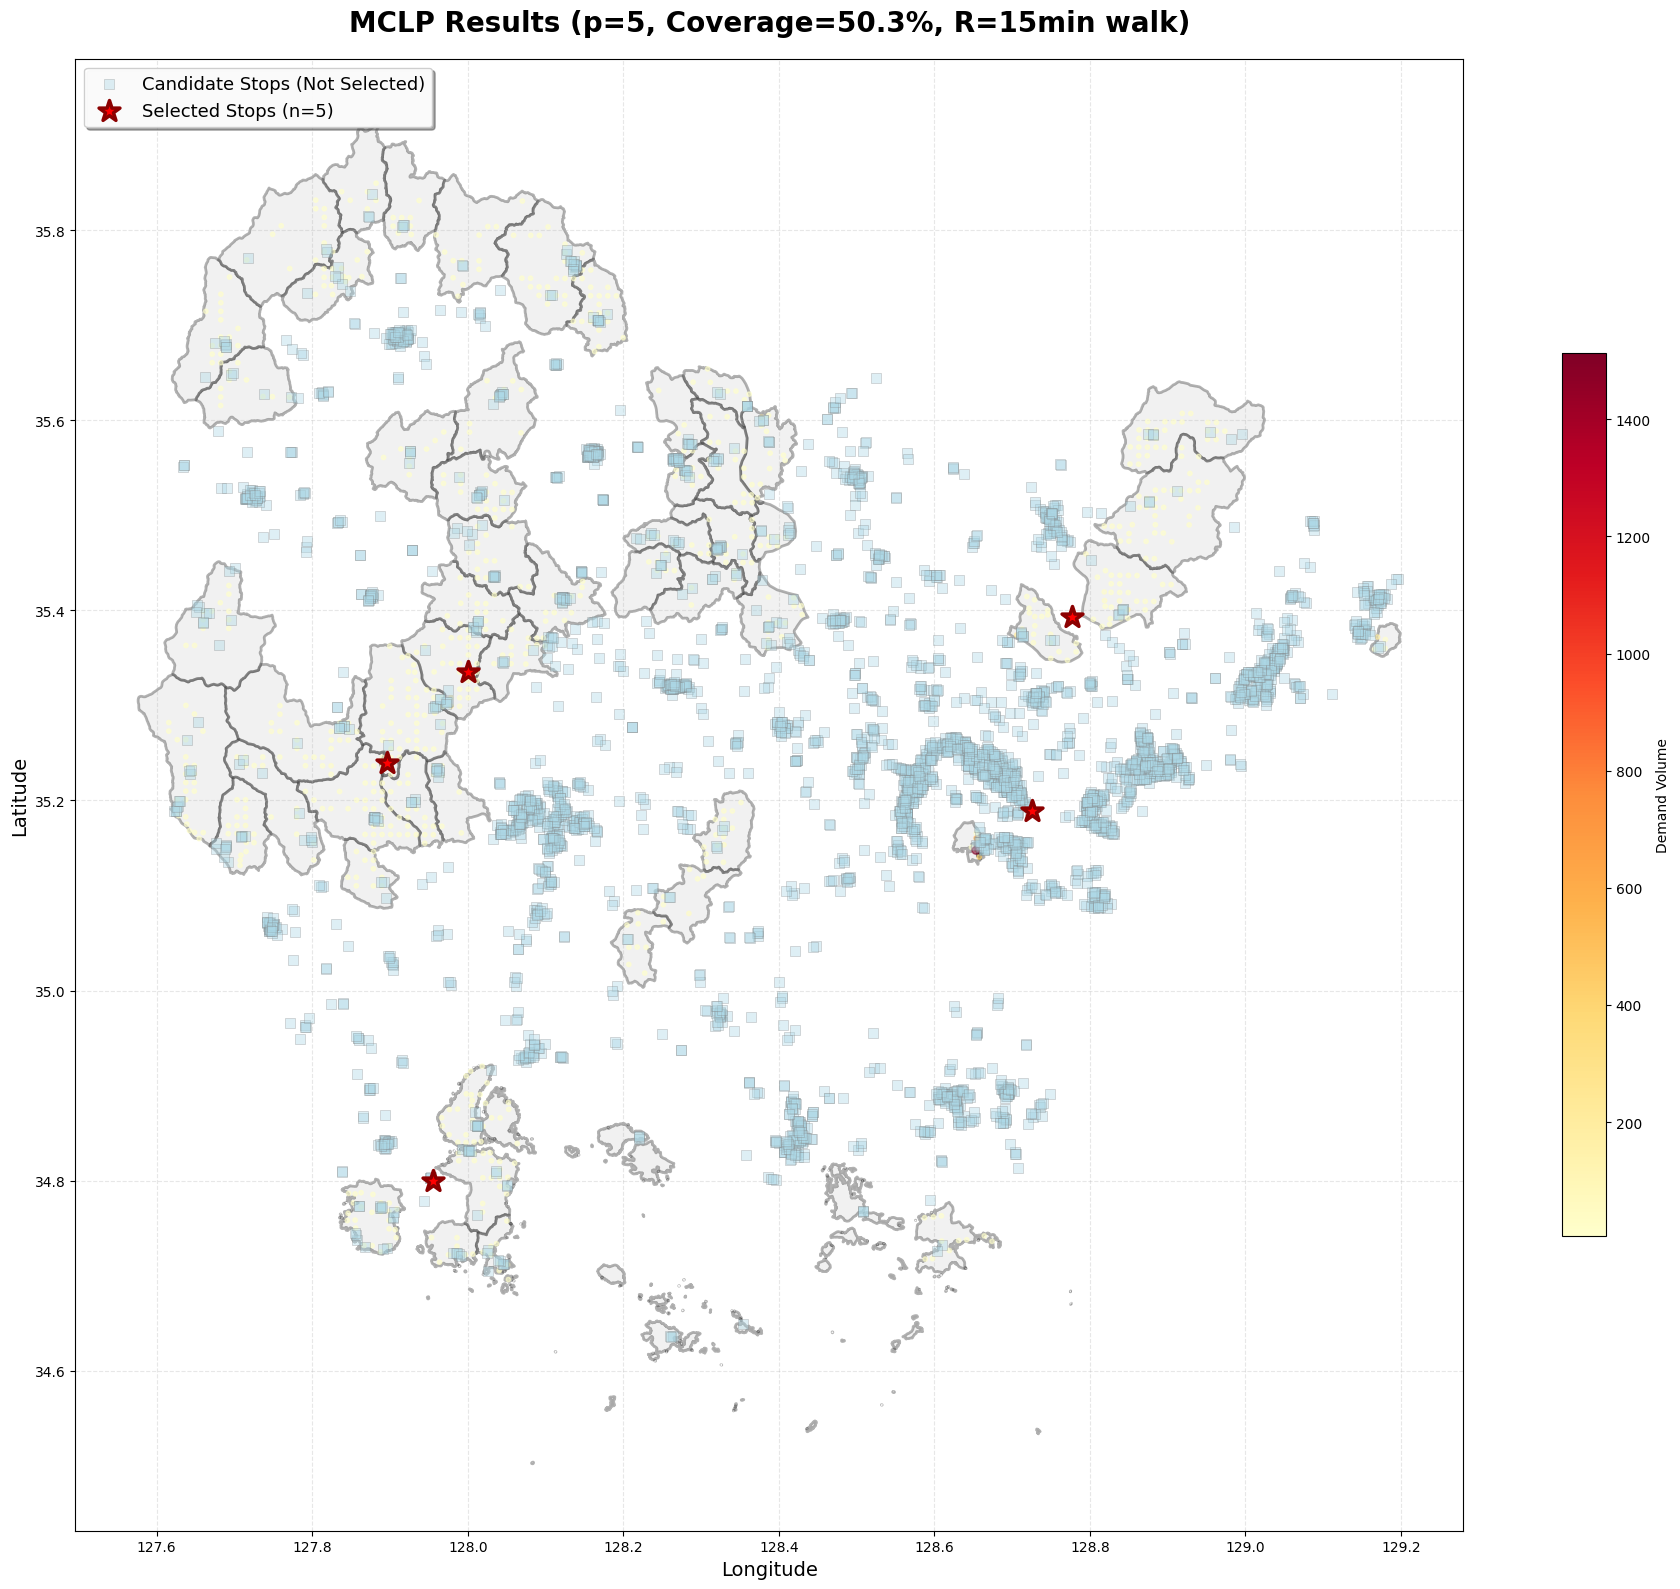

✅ 지도 저장: mclp_result_map.png


In [12]:
# 시각화 1: 전체 개요
print("\n=== 지도 시각화 1: 전체 개요 ===")

fig, ax = plt.subplots(figsize=(20, 16))

# 배경: 우선순위 지역
priority_zone.plot(ax=ax, color='lightgray', alpha=0.3, edgecolor='black',
                   linewidth=2, label='Priority Zone', zorder=1)

# 수요점 (크기: 수요량에 비례, 색상: demand_total)
demand_filtered.plot(ax=ax, column='demand_total', cmap='YlOrRd',
                     markersize=np.clip(demand_filtered['demand_total']/50, 10, 200),
                     alpha=0.6, legend=True,
                     legend_kwds={'label': 'Demand Volume', 'shrink': 0.6, 'pad': 0.05},
                     zorder=2)

# 후보 정류장 (선정되지 않은 것)
non_selected = candidate[~candidate['nearest_node'].isin(selected_candidate_nodes)]
if len(non_selected) > 0:
    non_selected.plot(ax=ax, color='lightblue', markersize=60,
                      alpha=0.4, marker='s', label='Candidate Stops (Not Selected)',
                      edgecolor='gray', linewidth=0.5, zorder=3)

# 선정된 정류장 (강조)
final_selected_candidates.plot(ax=ax, color='red', markersize=250,
                               marker='*', edgecolor='darkred',
                               linewidth=2.5, label=f'Selected Stops (n={len(final_selected_candidates)})',
                               zorder=5)

ax.set_title(f'MCLP Results (p={optimal_p}, Coverage={final_rate:.1f}%, R={R_seconds/60:.0f}min walk)',
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# 범례 위치 조정
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left', fontsize=13, framealpha=0.95,
          shadow=True, fancybox=True)

ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('mclp_result_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 지도 저장: mclp_result_map.png")


=== 지도 시각화 2: 커버리지 상세 ===


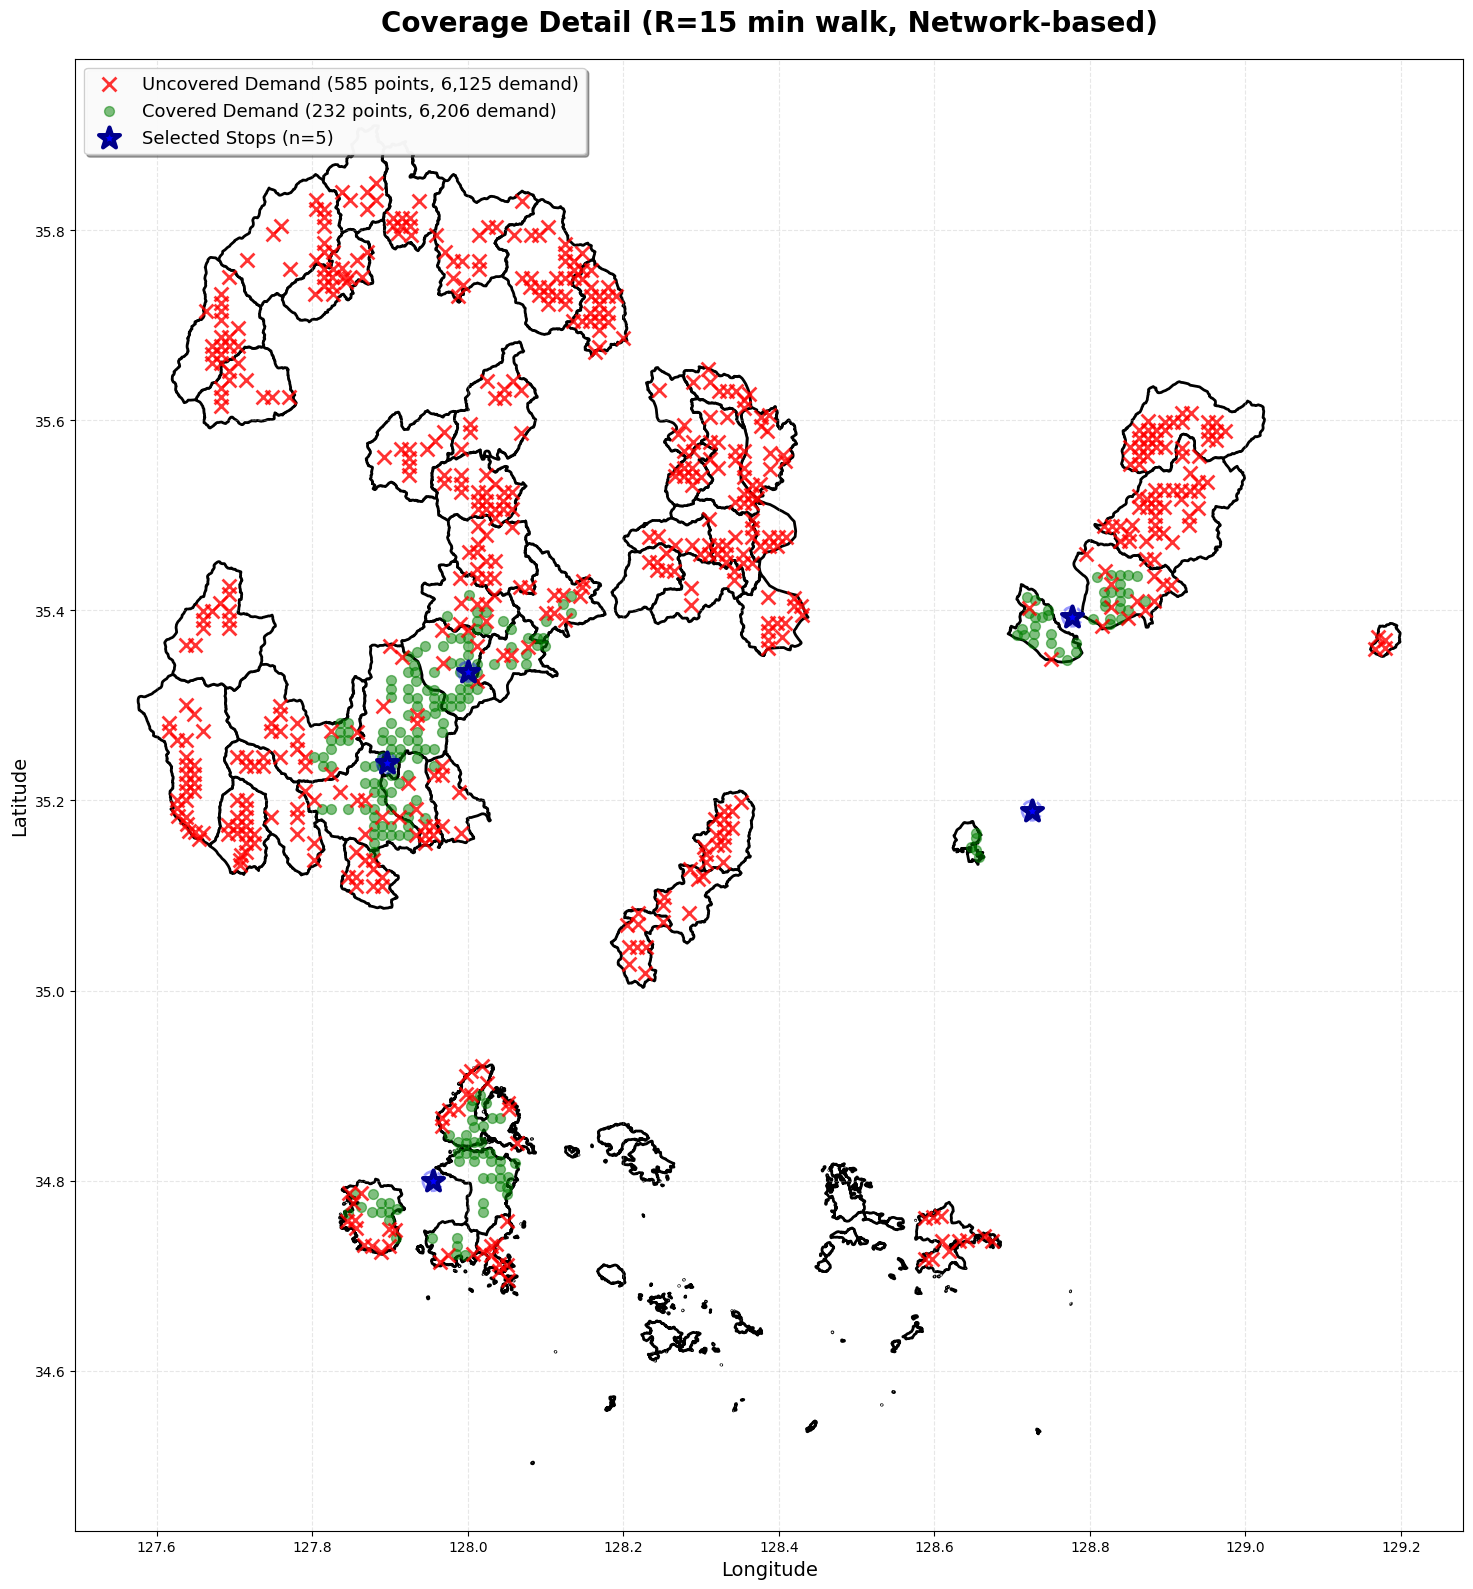

✅ 커버리지 상세 지도 저장: mclp_coverage_detail.png


In [13]:
# 시각화 2: 커버리지 상세
print("\n=== 지도 시각화 2: 커버리지 상세 ===")

fig, ax = plt.subplots(figsize=(20, 16))

# 배경
priority_zone.plot(ax=ax, color='white', edgecolor='black', linewidth=2, zorder=1)

# 커버되지 않은 수요점 (빨간색, X 표시)
if len(uncovered) > 0:
    uncovered.plot(ax=ax, color='red', markersize=100, alpha=0.8,
                   label=f'Uncovered Demand ({len(uncovered)} points, {uncovered["demand_total"].sum():,.0f} demand)',
                   marker='x', linewidth=2, zorder=3)

# 커버된 수요점 (초록색)
if len(covered) > 0:
    covered.plot(ax=ax, color='green', markersize=50, alpha=0.5,
                 label=f'Covered Demand ({len(covered)} points, {covered["demand_total"].sum():,.0f} demand)',
                 marker='o', zorder=2)

# 선정된 정류장
final_selected_candidates.plot(ax=ax, color='blue', markersize=250,
                               marker='*', edgecolor='darkblue',
                               linewidth=3, label=f'Selected Stops (n={len(final_selected_candidates)})',
                               zorder=5)

# 커버리지 원 표시 (R 거리, 대략적 표시)
walk_distance_m = R_seconds * 1.25
degree_per_meter = 1 / 111000

for idx, row in final_selected_candidates.iterrows():
    # 위도에 따른 경도 보정
    lat_correction = np.cos(np.radians(row.geometry.y))
    radius_lon = walk_distance_m * degree_per_meter / lat_correction
    radius_lat = walk_distance_m * degree_per_meter

    # 타원 (경도/위도 비율 고려)
    from matplotlib.patches import Ellipse
    ellipse = Ellipse((row.geometry.x, row.geometry.y),
                     width=radius_lon*2, height=radius_lat*2,
                     color='blue', fill=False, linestyle='--',
                     linewidth=2, alpha=0.4, zorder=4)
    ax.add_patch(ellipse)
ax.set_title(f'Coverage Detail (R={R_seconds/60:.0f} min walk, Network-based)',
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

ax.legend(loc='upper left', fontsize=13, framealpha=0.95, shadow=True, fancybox=True)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('mclp_coverage_detail.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 커버리지 상세 지도 저장: mclp_coverage_detail.png")

In [14]:
# 각 선정된 정류장이 커버하는 수요 계산
print("\n=== 추가 분석: 정류장별 커버 수요 ===")

stop_coverage_stats = []

for idx, (j_matrix_idx, candidate_node_id) in enumerate(zip(final_selected_indices, selected_candidate_nodes)):
    # 해당 정류장이 커버하는 수요점들 (indices in demand_nodes) - 이는 MCLP 모델에 전달된 고유 수요 노드의 인덱스입니다.
    covered_demand_node_indices_by_this_candidate = coverage_matrix[:, j_matrix_idx].nonzero()[0]

    # 이 정류장이 커버하는 고유 수요 노드들의 집계된 수요량 합산
    # MCLP 모델의 수요량 가중치(demand_weights_array) 기준으로 합산합니다.
    covered_demand_amount = sum(demand_weights_array[i] for i in covered_demand_node_indices_by_this_candidate)

    # 해당 노드들에 매칭되는 demand_filtered 행의 총 개수 (원본 수요점의 개수)
    covered_osm_nodes = [demand_nodes[i] for i in covered_demand_node_indices_by_this_candidate]
    covered_points_raw = demand_filtered[demand_filtered['nearest_node'].isin(covered_osm_nodes)].shape[0]

    # 정류장 위치 정보
    stop_info = final_selected_candidates[
        final_selected_candidates['nearest_node'] == candidate_node_id
    ].iloc[0]

    stop_coverage_stats.append({
        'stop_id': idx + 1,
        'candidate_node': candidate_node_id,
        'longitude': stop_info.geometry.x,
        'latitude': stop_info.geometry.y,
        'covered_points_raw': covered_points_raw, # 각 정류장이 커버하는 원본 수요점의 총 개수 (중복 포함)
        'covered_demand': covered_demand_amount # MCLP 가중치 기준으로 집계된 수요량 (중복 커버된 수요도 포함될 수 있음)
    })

stop_coverage_df = pd.DataFrame(stop_coverage_stats)
stop_coverage_df = stop_coverage_df.sort_values('covered_demand', ascending=False)

print(f"\n상위 {min(10, len(stop_coverage_df))}개 정류장 (커버 수요 기준):")
print(stop_coverage_df.head(10).to_string(index=False))

# 저장
stop_coverage_df.to_csv('stop_coverage_analysis.csv', index=False, encoding='utf-8-sig')
print("\n✅ 정류장별 분석 저장: stop_coverage_analysis.csv")


=== 추가 분석: 정류장별 커버 수요 ===

상위 5개 정류장 (커버 수요 기준):
 stop_id  candidate_node  longitude  latitude  covered_points_raw  covered_demand
       2      8953028934 128.725253 35.189242                   5            2527
       3      9310581683 127.895941 35.238899                  83            1387
       4      7541974020 127.999737 35.335413                  77            1089
       5     13018975715 128.777169 35.393382                  39             974
       1      4636879118 127.954671 34.799435                  52             819

✅ 정류장별 분석 저장: stop_coverage_analysis.csv


선정된 각 정류장이 커버하는 사각지대 청소년(수요량)은 다음과 같습니다.

*   `stop_id`: 정류장의 고유 식별 번호입니다.
*   `candidate_node`: 해당 정류장이 매칭된 도보망 네트워크 노드 ID입니다.
*   `longitude`, `latitude`: 정류장의 경도와 위도입니다.
*   `covered_points`: 해당 정류장이 커버하는 수요점(즉, 사각지대 청소년 그룹)의 수입니다.
*   `covered_demand`: 해당 정류장이 커버하는 총 수요량(사각지대 청소년 수)입니다.


=== 추가 시각화: 정류장 중요도 지도 ===


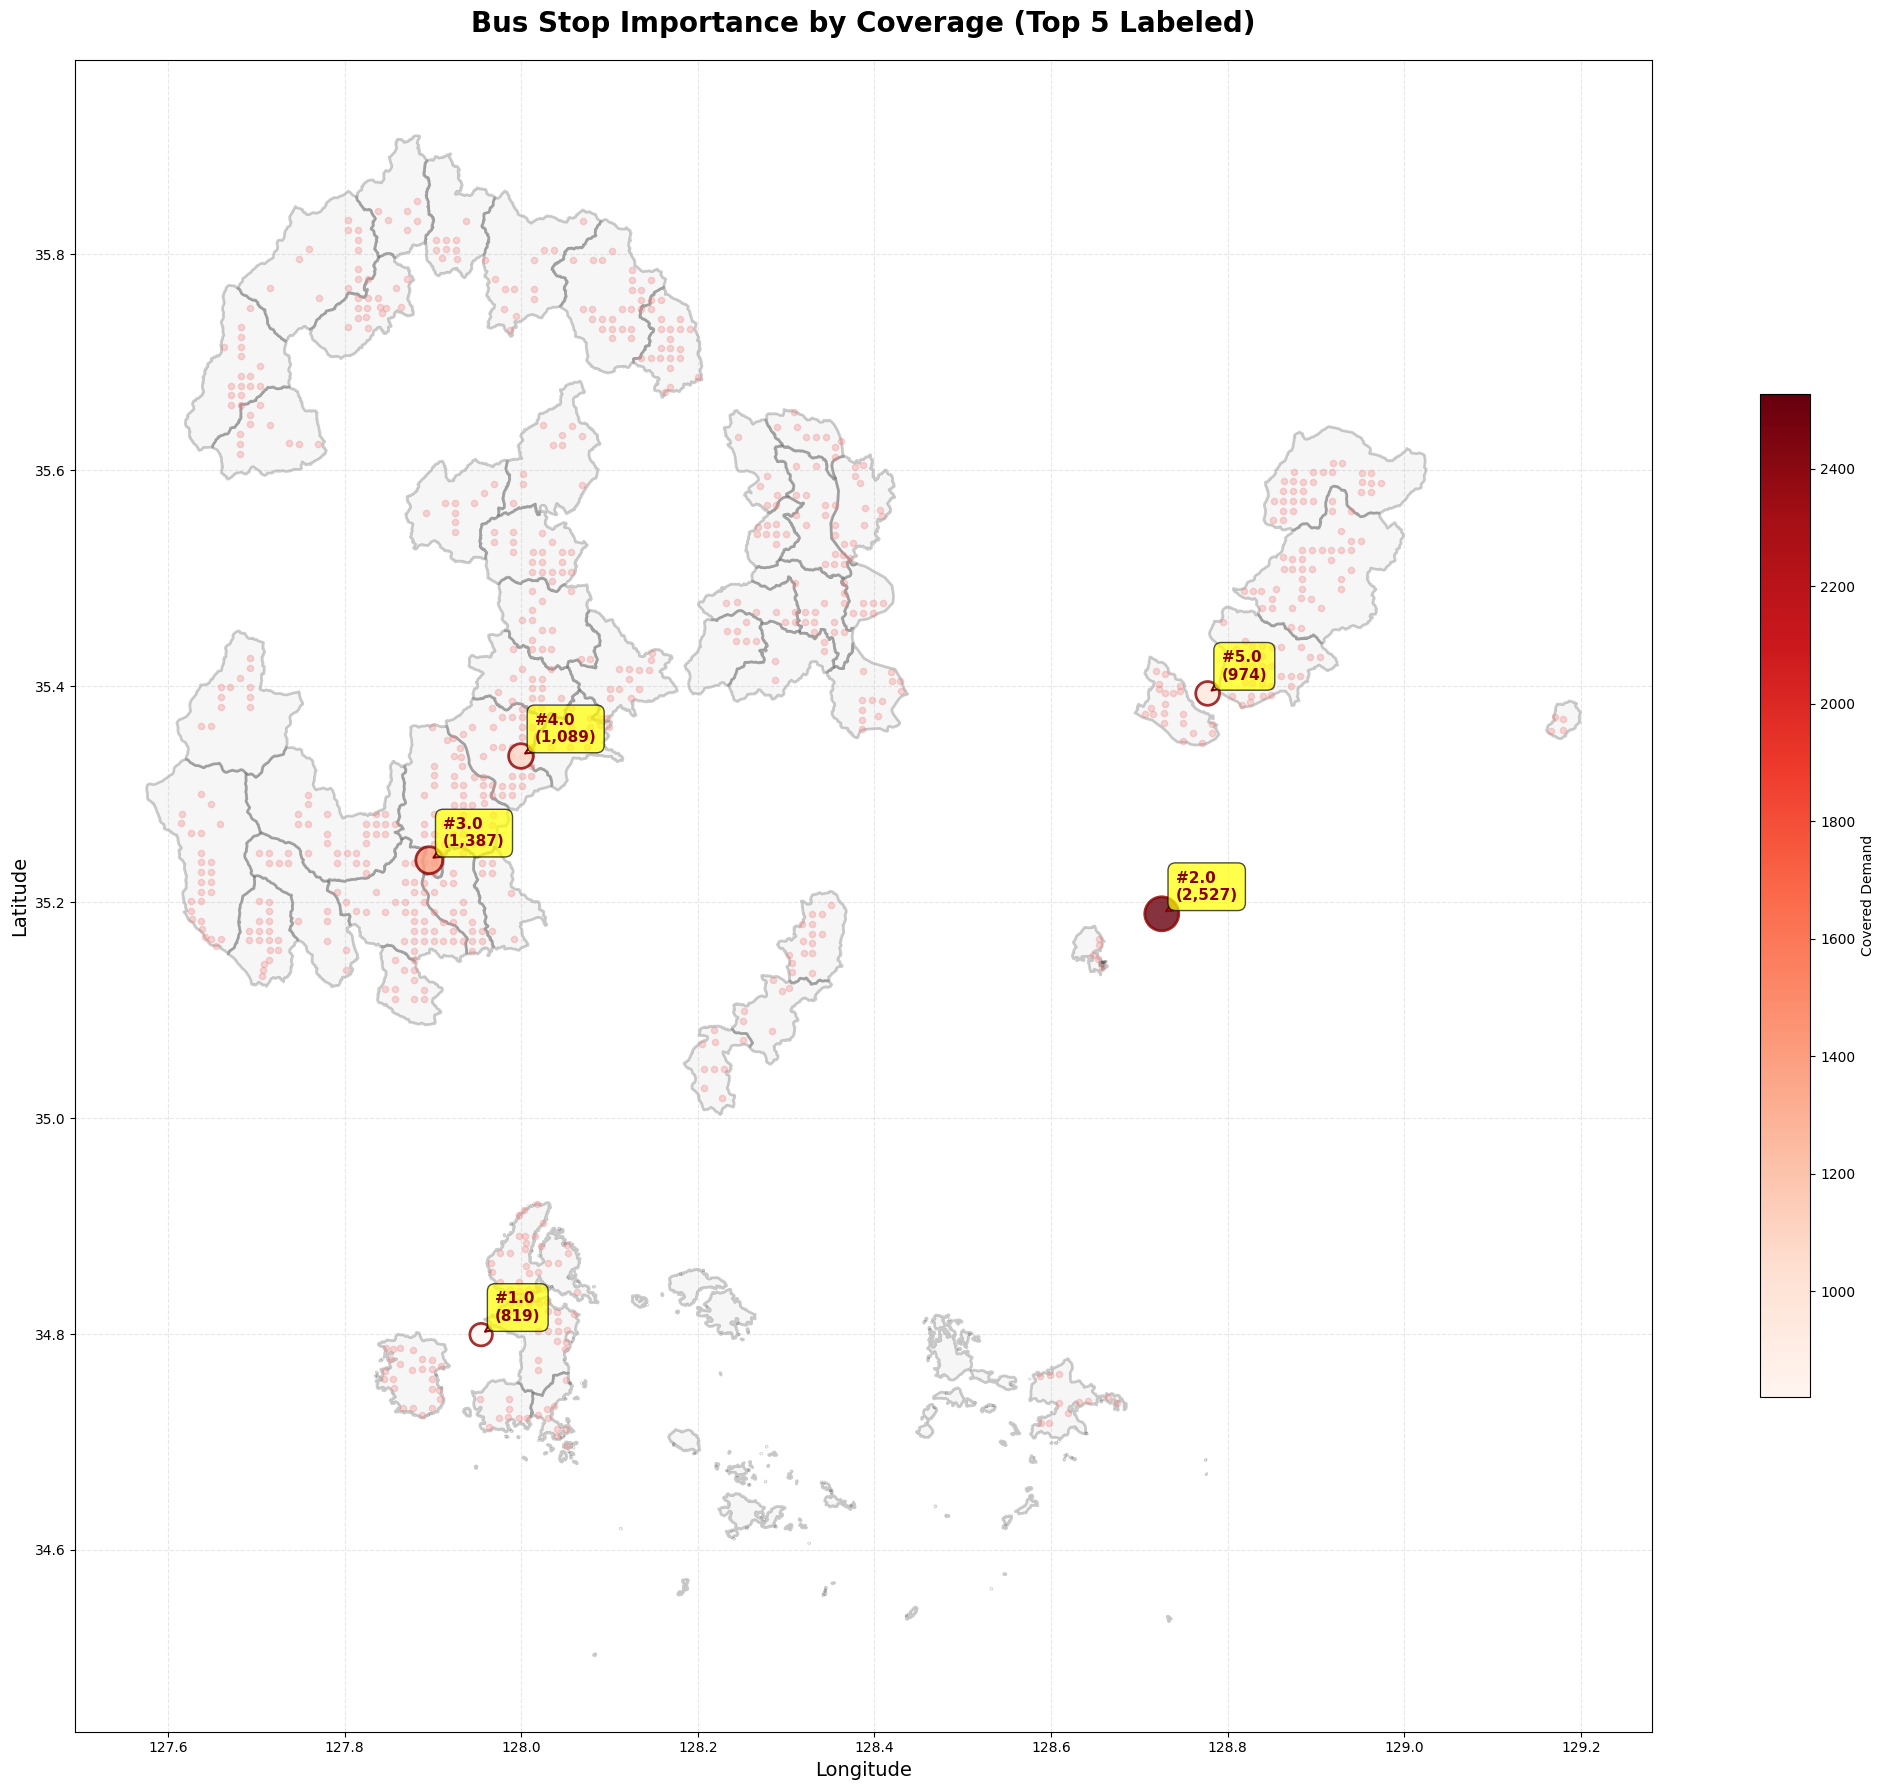

✅ 정류장 중요도 지도 저장: mclp_stop_importance.png


In [15]:
print("\n=== 추가 시각화: 정류장 중요도 지도 ===")

# 정류장 중요도 정보를 GeoDataFrame에 병합
final_selected_with_stats = final_selected_candidates.copy()
final_selected_with_stats['stop_id'] = range(1, len(final_selected_with_stats) + 1)

# nearest_node 기준으로 병합
node_to_coverage = stop_coverage_df.set_index('candidate_node')['covered_demand'].to_dict()
final_selected_with_stats['covered_demand'] = final_selected_with_stats['nearest_node'].map(node_to_coverage)

fig, ax = plt.subplots(figsize=(22, 18))

# 배경
priority_zone.plot(ax=ax, color='lightgray', alpha=0.2, edgecolor='black',
                   linewidth=2, zorder=1)

# 수요점 (연한 색)
demand_filtered.plot(ax=ax, color='lightcoral', markersize=20, alpha=0.3, zorder=2)

# 선정된 정류장 (크기와 색상 = 커버 수요량)
final_selected_with_stats.plot(
    ax=ax,
    column='covered_demand',
    cmap='Reds',
    markersize=final_selected_with_stats['covered_demand'] / final_selected_with_stats['covered_demand'].max() * 500 + 100,
    marker='o',
    edgecolor='darkred',
    linewidth=2,
    alpha=0.8,
    legend=True,
    legend_kwds={'label': 'Covered Demand', 'shrink': 0.6},
    zorder=5
)

# 상위 5개 정류장에 라벨 추가
top5_stops = stop_coverage_df.head(5)
for _, row in top5_stops.iterrows():
    ax.annotate(
        f"#{row['stop_id']}\n({row['covered_demand']:,.0f})",
        xy=(row['longitude'], row['latitude']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=11,
        fontweight='bold',
        color='darkred',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
        arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5),
        zorder=6
    )

ax.set_title(f'Bus Stop Importance by Coverage (Top 5 Labeled)',
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('mclp_stop_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 정류장 중요도 지도 저장: mclp_stop_importance.png")

In [16]:
# 결과 요약
print("\n" + "="*70)
print(" "*20 + "MCLP 분석 최종 보고서")
print("="*70)

# MCLP 솔버가 보고한 커버 수요량 (final_covered)를 기준으로 '커버된_수요점_수'를 다시 계산
# final_covered는 demand_weights_array를 사용하므로, 이는 '수요량'의 합계임.
# '커버된_수요점_수'는 `covered` DataFrame의 행의 수로 정의하는 것이 일관성을 유지하기에 적합함.
# `covered`와 `uncovered`는 이미 `final_y_vars_solution`을 통해 정확히 계산될 것임.

summary = {
    '최적_정류장_수': optimal_p,
    '선정된_정류장_수': len(final_selected_candidates),
    '총_후보지_수': len(candidate),
    '총_수요점_수': len(demand_filtered), # 원본 수요점 수
    '커버된_수요점_수': len(covered), # 커버된 원본 수요점 수
    '커버_안된_수요점_수': len(uncovered), # 커버 안된 원본 수요점 수
    '총_수요량': total_demand, # 원본 수요량 합계
    '커버된_수요량': final_covered, # MCLP가 커버한 수요량 (demand_weights_array 기반)
    '커버_안된_수요량': uncovered['demand_total'].sum() if len(uncovered) > 0 else 0, # 커버 안된 원본 수요량 합계
    '커버리지율_percentage': final_rate,
    '도보_시간_기준_분': R_seconds / 60,
    '도보_거리_미터': walk_distance_m,
    '평균_도보_속도_kmh': 4.5,
    '네트워크_노드수': len(G_walk.nodes),
    '네트워크_엣지수': len(G_walk.edges),
    '평균_매칭_거리_m': demand_filtered['match_distance_m'].mean()
}

summary_df = pd.DataFrame([summary]).T
summary_df.columns = ['값']

print(f"""
📊 분석 개요
-----------
- 분석 대상 지역: 최우선 클러스터 (Priority Zone)
- 분석 방법: MCLP (Maximal Covering Location Problem)
- 네트워크: 도보망 (Walk Network)
- 커버리지 기준: {R_seconds/60:.0f}분 ({R_seconds}초) 도보 시간
- 도보 거리: 약 {walk_distance_m:.0f}m

📍 입력 데이터
-------------
- 총 후보 정류장: {len(candidate):,}개
- 필터링된 수요점: {len(demand_filtered):,}개
- 총 수요량: {total_demand:,.0f}
- 우선순위 지역 수: {len(priority_zone)}개

🌐 네트워크 정보
--------------
- 도보망 노드 수: {len(G_walk.nodes):,}개
- 도보망 엣지 수: {len(G_walk.edges):,}개
- 평균 도보 속도: 4.5 km/h
- 평균 매칭 거리: {demand_filtered['match_distance_m'].mean():.1f}m

🎯 최적화 결과
-------------
- 최적 정류장 수 (p): {optimal_p}개
- 선정된 정류장: {len(final_selected_candidates)}개
- 커버된 수요점: {len(covered):,}개 ({len(covered)/len(demand_filtered)*100:.1f}%) (원본 수요점 기준)
- 커버 안 된 수요점: {len(uncovered):,}개 ({len(uncovered)/len(demand_filtered)*100:.1f}%) (원본 수요점 기준)

💰 수요 커버리지
---------------
- MCLP 최적화 커버 수요량 (총합): {final_covered:,.0f} (MCLP 모델의 목적 함수 값)
- 커버된 원본 수요량 합계: {covered['demand_total'].sum():,.0f} (각 원본 수요점의 'demand_total' 합계)
- 커버 안 된 원본 수요량 합계: {uncovered['demand_total'].sum() if len(uncovered) > 0 else 0:,.0f}
- 전체 커버리지율: {final_rate:.2f}% (MCLP 최적화 커버 수요량 기준)

📈 효율성 지표
-------------
- 정류장당 평균 커버 수요점 (원본): {len(covered)/len(final_selected_candidates) if len(final_selected_candidates) > 0 else 0:.1f}개
- 정류장당 평균 커버 수요량 (MCLP 가중치 기반): {sum(s['covered_demand'] for s in stop_coverage_stats) / len(final_selected_candidates) if len(final_selected_candidates) > 0 else 0:,.0f}
- 커버리지 밀도: {coverage_density:.2f}%

📁 생성된 파일
-------------
1. mclp_selected_stops.geojson - 선정된 정류장 위치
2. demand_with_coverage.geojson - 커버리지 정보 포함 수요점
3. stop_coverage_analysis.csv - 정류장별 커버 수요 분석
4. mclp_coverage_curve.png - 커버리지 곡선
5. mclp_result_map.png - 전체 결과 지도
6. mclp_coverage_detail.png - 커버리지 상세 지도
7. mclp_stop_importance.png - 정류장 중요도 지도
8. mclp_summary.csv - 분석 요약 통계
9. mclp_coverage_curve.csv - p값별 커버리지 데이터
""")

print("="*70)

# CSV 저장
summary_df.to_csv('mclp_summary.csv', encoding='utf-8-sig')
results_df.to_csv('mclp_coverage_curve.csv', index=False, encoding='utf-8-sig')

print("✅ 요약 통계 저장 완료")
print("\n" + "="*70)
print(" "*15 + "✅ 모든 분석이 성공적으로 완료되었습니다!")
print("="*70)

# 주요 지표를 딕셔너리로 반환 (추가 분석용)
mclp_results = {
    'optimal_p': optimal_p,
    'selected_stops': final_selected_candidates,
    'coverage_rate': final_rate,
    'covered_demand': final_covered,
    'covered_points': covered,
    'uncovered_points': uncovered,
    'stop_stats': stop_coverage_df,
    'coverage_curve': results_df,
    'network': G_walk,
    'coverage_matrix': coverage_matrix,
    'final_y_vars_solution': final_y_vars_solution # 추가
}

print("\n💡 추가 분석을 위해 'mclp_results' 딕셔너리를 사용하세요.")
print("\n주요 변수:")
print("  - mclp_results['selected_stops']: 선정된 정류장 GeoDataFrame")
print("  - mclp_results['covered_points']: 커버된 수요점 GeoDataFrame")
print("  - mclp_results['uncovered_points']: 커버 안 된 수요점 GeoDataFrame")
print("  - mclp_results['stop_stats']: 정류장별 통계 DataFrame")
print("  - mclp_results['coverage_curve']: p값별 커버리지 DataFrame")
print("  - mclp_results['final_y_vars_solution']: MCLP 솔버가 판단한 최종 수요점 커버 여부 (True/False 배열)")


                    MCLP 분석 최종 보고서

📊 분석 개요
-----------
- 분석 대상 지역: 최우선 클러스터 (Priority Zone)
- 분석 방법: MCLP (Maximal Covering Location Problem)
- 네트워크: 도보망 (Walk Network)
- 커버리지 기준: 15분 (900초) 도보 시간
- 도보 거리: 약 1125m

📍 입력 데이터
-------------
- 총 후보 정류장: 3,700개
- 필터링된 수요점: 817개
- 총 수요량: 12,331
- 우선순위 지역 수: 61개

🌐 네트워크 정보
--------------
- 도보망 노드 수: 293,894개
- 도보망 엣지 수: 814,886개
- 평균 도보 속도: 4.5 km/h
- 평균 매칭 거리: 248.7m

🎯 최적화 결과
-------------
- 최적 정류장 수 (p): 5개
- 선정된 정류장: 5개
- 커버된 수요점: 232개 (28.4%) (원본 수요점 기준)
- 커버 안 된 수요점: 585개 (71.6%) (원본 수요점 기준)

💰 수요 커버리지
---------------
- MCLP 최적화 커버 수요량 (총합): 6,206 (MCLP 모델의 목적 함수 값)
- 커버된 원본 수요량 합계: 6,206 (각 원본 수요점의 'demand_total' 합계)
- 커버 안 된 원본 수요량 합계: 6,125
- 전체 커버리지율: 50.33% (MCLP 최적화 커버 수요량 기준)

📈 효율성 지표
-------------
- 정류장당 평균 커버 수요점 (원본): 46.4개
- 정류장당 평균 커버 수요량 (MCLP 가중치 기반): 1,359
- 커버리지 밀도: 0.65%

📁 생성된 파일
-------------
1. mclp_selected_stops.geojson - 선정된 정류장 위치
2. demand_with_coverage.geojson - 커버리지 정보 포함 수요점
3. stop_coverage_analysis.csv -